In [1]:
import pandas as pd
import torch
from chronos import ChronosPipeline
import matplotlib.pyplot as plt
import numpy as np

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

C:\Users\TEO\anaconda3\envs\chronos\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
C:\Users\TEO\anaconda3\envs\chronos\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\TEO\anaconda3\envs\chronos\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [2]:
df = pd.read_csv('AAPL.csv')

# Drop null values
# df.dropna(inplace=True)
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,ts_polarity,twitter_volume
1183,2020-09-15,118.33,118.83,113.61,115.54,115.54,184642000,NaN,NaN
1184,2020-09-16,115.23,116.00,112.04,112.13,112.13,154679000,NaN,NaN
1185,2020-09-17,109.72,112.20,108.71,110.34,110.34,178011000,NaN,NaN
1186,2020-09-18,110.40,110.88,106.09,106.84,106.84,287104900,NaN,NaN
1187,2020-09-21,104.54,110.19,103.10,110.08,110.08,195050000,NaN,NaN


In [3]:
# pct change based on Adj close value
df["Pct_change"] = df["Adj Close"].pct_change()

# Drop null values
# df.dropna(inplace = True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ts_polarity,twitter_volume,Pct_change
0,2016-01-04,25.65,26.34,25.50,26.34,24.44,270597600,0.070389,1133.0,NaN
1,2016-01-05,26.44,26.46,25.60,25.68,23.83,223164000,0.133635,1430.0,-0.024959
2,2016-01-06,25.14,25.59,24.97,25.17,23.36,273829600,0.072042,1949.0,-0.019723
3,2016-01-07,24.67,25.03,24.11,24.11,22.38,324377600,0.074369,2289.0,-0.041952
4,2016-01-08,24.64,24.78,24.19,24.24,22.50,283192000,0.051595,2235.0,0.005362


In [4]:
# Convert the "Date" column to datetime if it's not already in datetime format
df["Date"] = pd.to_datetime(df["Date"])

In [5]:
# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension

context = torch.tensor(df["Close"])

In [6]:
prediction_length = 30  # 1 month
forecast = pipeline.predict(
    context, prediction_length
)  # shape [num_series, num_samples, prediction_length]
pipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-small", device_map="cpu", torch_dtype=torch.float32)
# visualize the forecast
# forecast_index = range(len(df), len(df) + prediction_length)

C:\Users\TEO\anaconda3\envs\chronos\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
# Generate forecast index for plotting
last_date = df["Date"].iloc[-1]
forecast_index = pd.date_range(
    start=last_date + pd.Timedelta(days=1), periods=prediction_length, freq='D'
)

low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

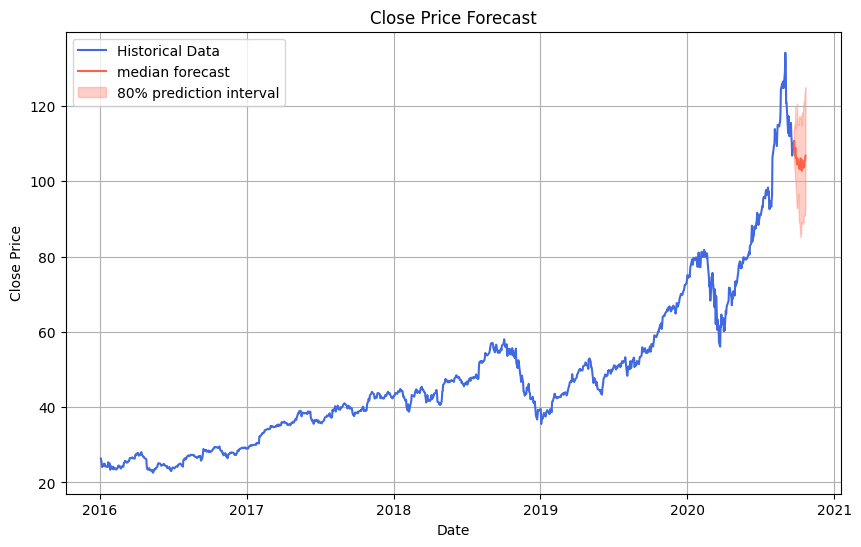

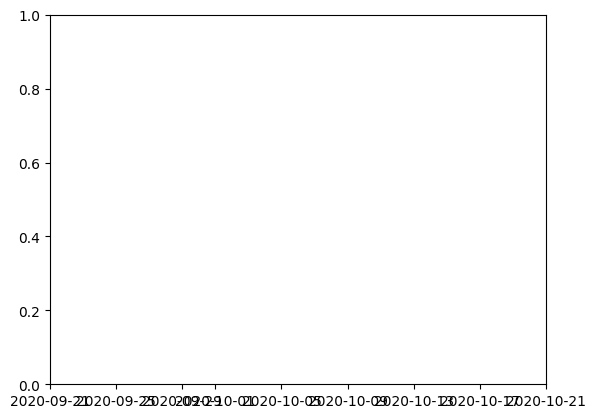

In [8]:
# plt.figure(figsize=(8, 4))
plt.figure(figsize=(10, 6))
# plt.plot(df["#Passengers"], color="royalblue", label="historical data")
plt.plot(df["Date"], df["Close"], color="royalblue", label="Historical Data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(
    forecast_index,
    low,
    high,
    color="tomato",
    alpha=0.3,
    label="80% prediction interval",
)
plt.title("Close Price Forecast")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.savefig("forecast_plot.png")
plt.show()
# Zoom in on the forecasted portion
plt.xlim(last_date, last_date + pd.Timedelta(days=prediction_length))
plt.savefig("forecast_plot_zoomed.png")